In [92]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [93]:
import numpy as np
import pandas as pd

In [94]:
import datetime as dt

In [95]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [96]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [97]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [98]:
# We can view all of the classes that automap found
Base.classes.keys()
print(type)

<class 'type'>


In [99]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [100]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [101]:
# creates a query selecting all the column information from the station table
# fetchall() selects all of the rows associated with the query
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [102]:
# creates a query selecting all the column information from the measurement table
# fetchall() selects all of the rows associated with the query
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [103]:
# Calculate the date 1 year ago from the last data point in the database
# set recent_date to the query showing date ordered in descending order with only the first
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [104]:
# Returns numpy array of datetime.date objects(recent_date) minus the difference between two dates / in this case a year
date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(date)

2016-08-23


In [105]:
# Perform a query to retrieve the data and precipitation scores
# set to pull precipitation based on date
# then filter by anything starting after the beginning date
# then it pulled all the dates
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= date).\
    order_by(Measurement.date).all()

In [106]:
# save as dataframe and set index to date 
# save precipitation to a dataframe
precipitation_df = pd.DataFrame(precipitation)
precipitation_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [107]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# set precipitation_df as an index to the dated column, only showing the first 5
precipitation_df.set_index("date").head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


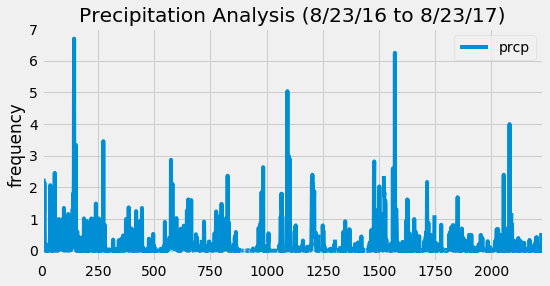

In [121]:
# Sort the dataframe by date
precipitation_df.sort_values(by=['date'])
# Use Pandas Plotting with Matplotlib to plot the data
# this involves setting the title and y label
# Set the dataframe to a plot
ax = precipitation_df.plot(figsize=(8,4))
ax.set_title("Precipitation Analysis (8/23/16 to 8/23/17)")
ax.set_ylabel('frequency')
plt.show()

In [109]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# use the describe function to list the statistics of the data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [110]:
# Design a query to show how many stations are available in this dataset?
# set a qeury into the the measurements, grouping by the station and setting a count to the stations
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations available.".format(locations))

There are 9 stations available.


In [111]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# set a query into station, counting station, then labels based on the string of count
# this is grouped by station then ordered by descending count for all
active = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
            group_by(Measurement.station).\
            order_by(desc('count')).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [112]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# set a query into station, counting station, then labels based on the string of count
# this is grouped by station then ordered by descending count for a limit of the first 10 based on the first row, first column
most_active = session.query(Measurement.station, 
                                    func.count(Measurement.station).\
                                    label('count')).\
                                    group_by(Measurement.station).\
                                    order_by(desc('count')).limit(10)[0][0]
most_active

'USC00519281'

In [113]:
# set the temperature based on the min, max, avg
# set a query based on the temp, filtured by the most active station
temp = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
session.query(*temp).filter(Measurement.station==most_active).all()

[(54.0, 85.0, 71.66378066378067)]

In [114]:
# Choose the station with the highest number of temperature observations.
# set a query for the tobs, filtered through the most active station, then greater than or equal to the last date
# set the query ordered descending for all
# set this information to a dataframe
temp_obs = session.query(Measurement.tobs).\
                                filter(Measurement.station==most_active).\
                                filter(Measurement.date >= date).\
                                order_by(Measurement.date.desc()).all()
temp_obs_df = pd.DataFrame(temp_obs)
temp_obs_df.head()

,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


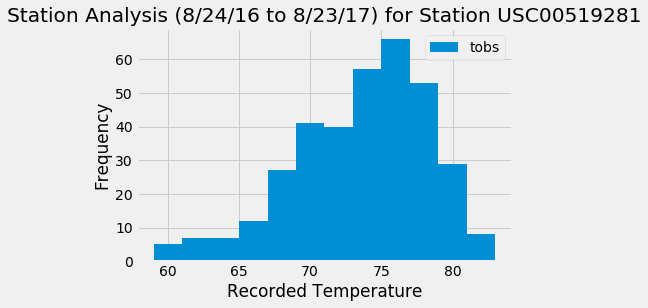

In [115]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(temp_obs_df['tobs'], bins=12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + most_active)
plt.legend(["tobs"])
plt.show()

In [116]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [117]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_results = calc_temps('2017-07-10', '2017-07-15')
trip_results

[(69.0, 78.325, 82.0)]

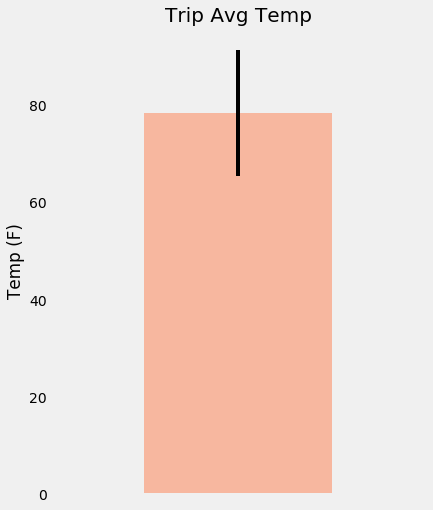

In [118]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.show()

### Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [90]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    Args:
        date (str): A date string in the format '%m-%d'
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    """
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
